<a href="https://colab.research.google.com/github/VictorrLiu/Draft_notebooks/blob/main/Xenium_Workshop_Part2_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: 10x Genomics does not provide support for community-developed tools and makes no guarantees regarding their function or performance. Please contact tool developers with any questions.*

# **Section 1. Install packages**

## **Section 1.a Install packages directly from R repositories. **

This takes very long time

**Not recommended in workshop**

It's recommended if you plan to run these analyses in your own computing system. It's always good to keep your packages always updated.

In [ ]:
system("sudo apt-get install libmagick++-dev")
install.packages("Seurat")
install.packages("harmony")
remotes::install_github('satijalab/seurat-wrappers')
devtools::install_github('immunogenomics/presto')
remotes::install_github("bnprks/BPCells/r")
install.packages("hdf5r")

## **Section 1.b Install packages by directly downloading pre-installed packages from AWS s3 bucket - R **
Recommended in a workshop as it's faster.

In [1]:
system("wget https://cf.10xgenomics.com/supp/xenium/analysis-workshop/R_library_v4-5.tar.gz")

# move all pre-installed R packages to default R folder path
system("tar -xzvf ./R_library_v4-5.tar.gz")
system(paste0("cp -r ./R_library_v4-5/* ", .libPaths()[1]))

Here, we are using two Xenium prime data generated from the same Xenium gene panel. We recommend integration of Xenium data generated from the same gene panel. The integration of Xenium data generated from different Xenium gene panels is not recommended, since gene probe sets and codewords can be different in different gene panels.


The two Xenium data used in this sections are:
1.   [Human breast cancer Xenium prime data](https://www.10xgenomics.com/datasets/xenium-prime-ffpe-human-breast-cancer)
2.   [Human cervical cancer Xenium prime data](https://www.10xgenomics.com/datasets/xenium-prime-ffpe-human-cervical-cancer)

The analysis goal of the integration between breast and cervical cancer Xenium prime data is to identify whether macrophages in these two cancer types could potentially have different function roles.



# **Section 2. Loading R packages**

In [2]:
library(Seurat)
library(ggplot2)
library(BPCells)
library(SeuratWrappers)
# this is needed for large datasets
options(future.globals.maxSize = 1e10)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.5.0 but the current version is
4.5.1; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




# **Section 3 Downloading breast and cervical Xenium prime data**

Here we will need `cell_feature_matrix.h5` from both breast and cervical Xenium prime outputs. We are downloading these two files from AWS for demo. This file can be easily found in Xenium output bundle.

1.   Human breast cancer Xenium prime: `./human_breast_xenium/cell_feature_matrix.h5`
2.   Human cervical cancer Xenium prime: `./human_cervical_xenium/cell_feature_matrix.h5`





In [3]:
system("wget https://cf.10xgenomics.com/supp/xenium/analysis-workshop/multi-sample-analysis.tar.gz")
system("tar -xzvf ./multi-sample-analysis.tar.gz")
system("mv multi-sample-analysis/human_breast_xenium ./")
system("mv multi-sample-analysis/human_cervical_xenium ./")

system("wget https://cf.10xgenomics.com/supp/xenium/analysis-workshop/multi-sample-analysis-intermediate-data.tar.gz")
system("tar -xzvf ./multi-sample-analysis-intermediate-data.tar.gz")

# **Section 4. Create on-disk representation for both Xenium data**



In [4]:
# load Xenium breast cancer data, and we only need "Gene Expression" feature
xenium.breast <- open_matrix_10x_hdf5(
  path = "./human_breast_xenium/cell_feature_matrix.h5",
  feature_type = "Gene Expression"
)

# Write the matrix on disk
write_matrix_dir(mat = xenium.breast,
                 dir = "./xenium_breast_matrix",
                 overwrite = TRUE)

5101 x 699110 IterableMatrix object with class MatrixDir

Row names: ENSG00000166535, ENSG00000127837 ... ENSG00000159840
Col names: aaaaaohf-1, aaaabkoj-1 ... oimkbodc-1

Data type: uint32_t
Storage order: column major

Queued Operations:
1. Load compressed matrix from directory /content/xenium_breast_matrix

**Task 1** - Create on-disk data for cervical cancer data and name it as `xenium_cervical_matrix`


In [5]:
# load Xenium cervical cancer data, and we only need "Gene Expression" feature
xenium.cervical <- open_matrix_10x_hdf5(
  path = "/content/human_cervical_xenium/cell_feature_matrix.h5",
  feature_type = "Gene Expression"
)

# Write the matrix on disk
write_matrix_dir(mat = xenium.cervical,
                 dir = "/content/xenium_cervical_matrix",
                overwrite = TRUE)

5101 x 840387 IterableMatrix object with class MatrixDir

Row names: ENSG00000166535, ENSG00000127837 ... ENSG00000159840
Col names: aaaabpen-1, aaaadiho-1 ... oinelbjb-1

Data type: uint32_t
Storage order: column major

Queued Operations:
1. Load compressed matrix from directory /content/xenium_cervical_matrix

Now we have matrix on disk. We can load on disk matrix.

Since there are multiple samples in this demo, it's a good practice to make cell IDs unique across all integrated samples. Here, we add suffix to cell IDs. For example, we add "_breast" suffix to each cell ID in breast cancer data and "_cervical" suffix to each cell ID in cervical cancer data.

By default, gene Ensembl IDs are used in output matrix. Ensembl IDs are not intuitive. Here we can convert Ensembl IDs to gene names. For each Xenium output bundle, there is a file `features.tsv.gz` within folder `cell_feature_matrix/`, which contains matched gene name for each gene Ensembl ID used in this data. We can use this file for conversion. This file has been downloaded in section 3.2.

In [6]:
# load on disk matrix
xenium.breast.count <- open_matrix_dir(dir = "./xenium_breast_matrix")

# add "_breast" suffix to cell IDs
colnames(xenium.breast.count) <- paste(colnames(xenium.breast.count),"breast",sep = "_")

# convert Ensembl IDs to gene names
features <- read.table("./human_breast_xenium/features.tsv.gz",
                       sep="\t", header=FALSE)
features <- features[(features$V3 == "Gene Expression"),]
features <- features[match(rownames(xenium.breast.count), features$V1),]
rownames(xenium.breast.count) <- features$V2

In [7]:
# we do the same thing for cervical cancer data

# load on disk cervical cancer matrix
xenium.cervical.count <- open_matrix_dir(dir = "/content/xenium_cervical_matrix")

# add "_cervical" suffix to cell IDs
colnames(xenium.cervical.count) <- paste(colnames(xenium.cervical.count),"cervical",sep = "_")

# convert Ensembl IDs to gene names
features <- read.table("/content/human_cervical_xenium/features.tsv.gz",
                       sep="\t", header=FALSE)
features <- features[(features$V3 == "Gene Expression"),]
features <- features[match(rownames(xenium.cervical.count), features$V1),]
rownames(xenium.cervical.count) <- features$V2

# **Section 5. Create a Seurat object (having both Xenium samples) with on-disk matrices**

In [8]:
# create a list having both breast and cervical on disk matrices
countlist <- list(xenium.breast.count, xenium.cervical.count)
names(countlist) <- c("breast","cervical")

**Task 2** - Create a Seurat object containing the list of breast and cervical on-disk matrices

We can simply use `CreateSeuratObject` on the list of matrices `countlist` to create a Seurat object.

In [9]:
# create a Seurat object for both breast and cervical data
merge.obj <- CreateSeuratObject(countlist)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [10]:
merge.obj

An object of class Seurat 
5101 features across 1539497 samples within 1 assay 
Active assay: RNA (5101 features, 0 variable features)
 2 layers present: counts.breast, counts.cervical

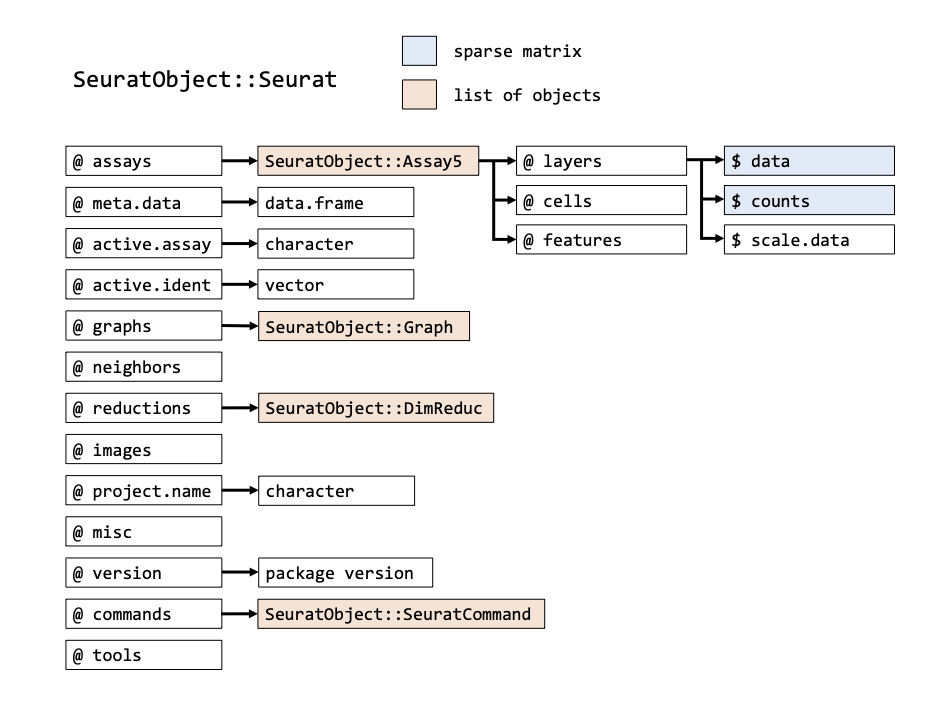


Image source: https://sib-swiss.github.io/single-cell-training/day1/day1-2_analysis_tools_qc.html

Since cells from both breast and cervical data are in one Seurat object, let's add one column `sample` to Seurat meta.data showing sample origin for each cell.

In [11]:
samples <- sapply(strsplit(colnames(merge.obj),"_"),function(X){return(X[2])})
merge.obj$samples <- samples

**Task 3** - check metadata in this Seurat object


In [12]:
metadata <- merge.obj
head(metadata, n=3)

orig.ident    nCount_RNA nFeature_RNA samples
aaaaaohf-1_breast SeuratProject 557        417          breast 
aaaabkoj-1_breast SeuratProject 832        557          breast 
aaaafefl-1_breast SeuratProject 544        426          breast

# **Section 6. "Sketch" subsampled cells and load these cells in memory**

The first step is QC. We want to remove cells with low transcript counts. Here we plot distribution of transcript count per cell in a histogram plot and based on it decide lower cutoff in transcript counts (aiming to remove cells with low transcript counts). The determination of lower cutoff can be subjective. There is no gold-standard rule.  

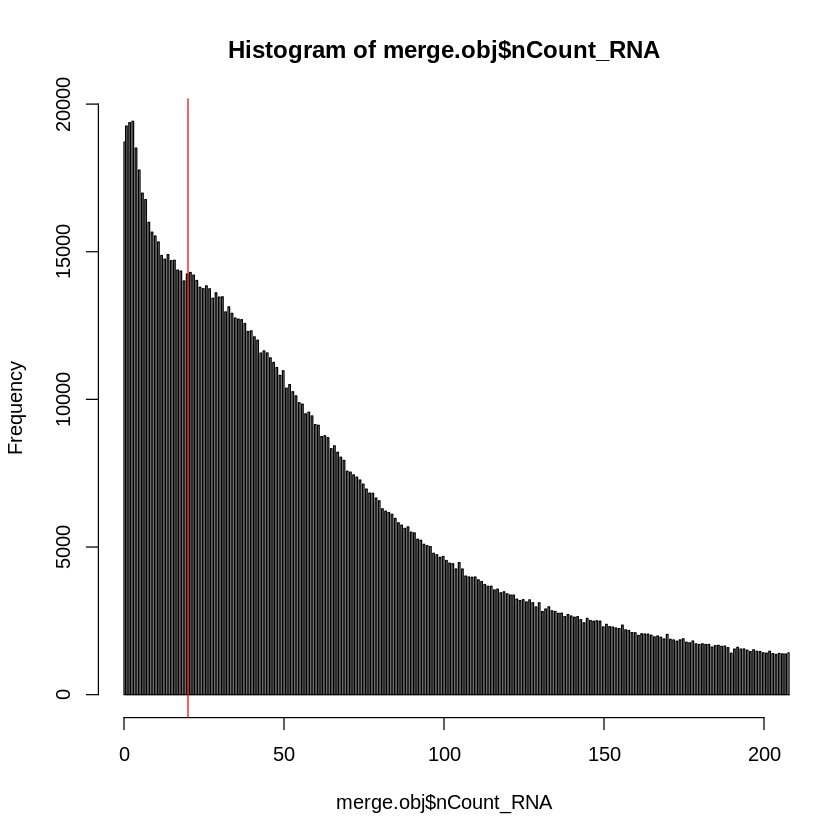

In [13]:
# based on the histogram plot, here we choose 20 transcript counts as lower cutoff
hist(merge.obj$nCount_RNA, xlim=c(0,200), breaks = 5000)
abline(v = 20, col="red")

In [14]:
## QC
## filtering cells based on detected transcripts per cell
## Upper limit cutoff - 98th percentile
## Lower limit cutoff - 20
# runtime: 43s
thres <- quantile(merge.obj$nCount_RNA, c(0.98))
merge.obj <- subset(merge.obj, subset = nCount_RNA >= 20 & nCount_RNA <= thres[1])

**Task 4** - Data normalization

We can use `NormalizeData` function to do normalization
-  scale.factor: median(merge.obj$nCount_RNA) - *`merge.obj$nCount_RNA` contains total transcript counts for each cell*

In [15]:
## Normalization
## library size based normalization, scale factor - median transcript count
## runtime: 28s
merge.obj <- NormalizeData(merge.obj, scale.factor = median(merge.obj$nCount_RNA))

Normalizing layer: counts.breast

Normalizing layer: counts.cervical



**Task 5** - Feature selection

We can use `FindVariableFeatures` function to do feature selection

In [16]:
## Find top 2k variable genes
# runtime: 18s
merge.obj <- FindVariableFeatures(merge.obj)

Finding variable features for layer counts.breast

Finding variable features for layer counts.cervical



We select 25k cells per each Xenium data (25k from breast data and 25k from cervical data). Sampling based on "LeverageScore" can retain rare cell populations. After sampling, we will get a new assay `sketch` consisting of 50k cells (these 50k cell data are in memory). We can switch assay from `sketch` to `RNA`, in order to switch in-memory data (50k cells) to on-disk data (all cells).

This step takes 3-4 mins.

**For in-person events, we will skip this step and directly load the pre-generated result from this step.**

In [17]:
############################ SKIP this step in workshop ###################################
## you will need to change ncells (downsample number) based on cell number you have per sample
## ncells = 25000 (meaning selecting 25k cells for each of both data);
## if we set ncells = c(25000, 35000), it will downsample 25k for breast data and 35k for cervical data
## runtime: 4mins
merge.obj <- SketchData(merge.obj, ncells = 25000,
                        method = "LeverageScore",
                        sketched.assay = "sketch",
                        features = VariableFeatures(merge.obj))

Calcuating Leverage Score



In [18]:
##################### load pre-generated result in workshop ###########################
merge.obj <- readRDS("./multi-sample-analysis-intermediate-data/Xenium_multiSample_integration_after_SketchData.rds")

In [19]:
merge.obj

An object of class Seurat 
10202 features across 1182865 samples within 2 assays 
Active assay: sketch (5101 features, 2000 variable features)
 4 layers present: counts.breast, counts.cervical, data.breast, data.cervical
 1 other assay present: RNA

# **Section 7. Conventional data processing**

Now we are doing analysis on the representative 50k cells (in `sketch` assay) downsampled from all cells (in `RNA` assay). Since only 50k cells, analysis is much faster. Conventional data processing including: find variable genes, data scaling, and PCA.

In [20]:
DefaultAssay(merge.obj) <- "sketch"

**Task 6** - Run the following codes in the correct order

There are three codes below but they are not in the correct order.

Please run each of them sequentially in the correct order.

In [23]:
# Run PCA
merge.obj <- RunPCA(merge.obj, verbose = FALSE)

In [21]:
# Find variable genes
merge.obj <- FindVariableFeatures(merge.obj, verbose = FALSE)

In [22]:
# Data scaling
merge.obj <- ScaleData(merge.obj, verbose = FALSE)

# **Section 8. Batch correction by Harmony**

Before doing batch correction, we can check if there are significant batch effects between these two data: project cells in 2D UAMP space without any batch correction and visualize cells by their sample origins. If most of cell types are very well separated between samples in UMAP space, it could indicate batch effects.

In [24]:
# directly run UMAP on uncorrected PCA results (aka without batch correction)
# runtime: 1min
merge.obj <- RunUMAP(merge.obj, dims = 1:30, reduction = "pca", return.model = TRUE, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


**Task 7** - Plot UMAP without batch correction

We can use `DimPlot` function to plot UMAP.
- group.by: samples - *labeling cells by sample origins*

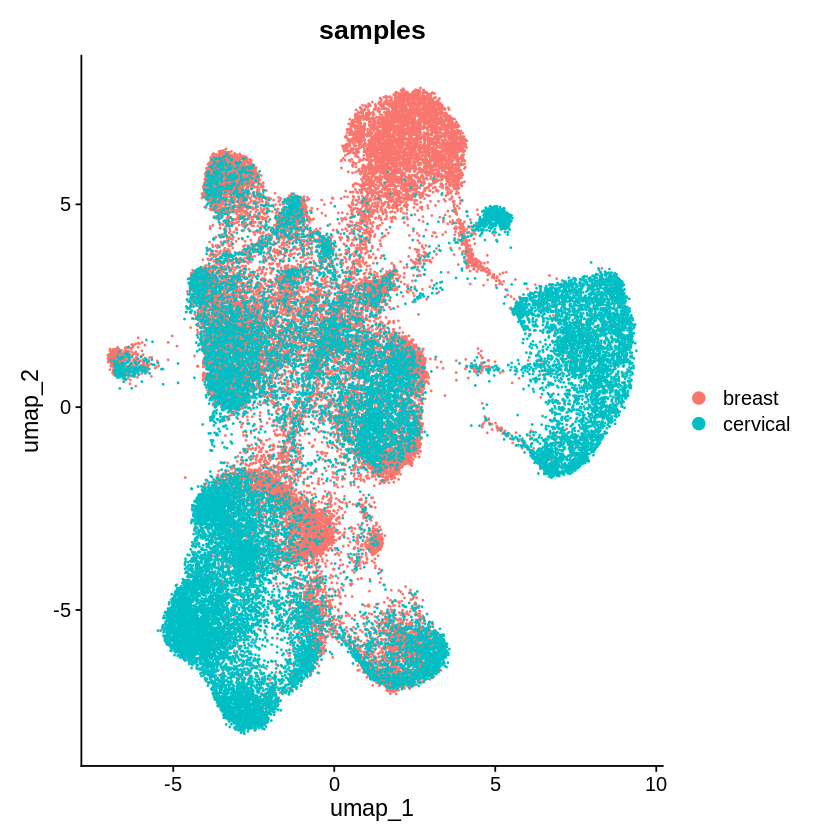

In [26]:
# plot UMAP and color cells by sample origins
DimPlot(merge.obj, group.by = "samples")

If there are significant batch effects, we can use Harmony to correct batch effects. In this demo, we continue doing batch correction using Harmony.

Harmony will correct `PCA` space (which contains variations from batch effects).

After removing batch effects, Harmony will generate new corrected reduced-dimension results, which we can call  `harmony` space.



In [27]:
## runtime: 1min
merge.obj <- IntegrateLayers(merge.obj, method = HarmonyIntegration,
                             orig = "pca", new.reduction = "harmony",
                             dims = 1:30)

The `features` argument is ignored by `HarmonyIntegration`.
This message is displayed once per session.
Transposing data matrix

Using automatic lambda estimation

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations



In [28]:
merge.obj

An object of class Seurat 
10202 features across 1182865 samples within 2 assays 
Active assay: sketch (5101 features, 2000 variable features)
 5 layers present: counts.breast, counts.cervical, data.breast, data.cervical, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

Based on batch corrected space - harmony, we can do UMAP projection and clustering.

**Task 8** - Fill in the correct reduction below

In [ ]:
# UMAP analysis based on batch corrected harmony space
# runtime: 1min
merge.obj <- RunUMAP(merge.obj, reduction = "harmony", dims = 1:30,
                    return.model = TRUE, verbose = FALSE)

In [ ]:
# clustering based on batch corrected harmony space
# runtime: 55s
merge.obj <- FindNeighbors(merge.obj, reduction = ADD_YOUR_CODE_HERE, dims = 1:30, verbose = FALSE)
merge.obj <- FindClusters(merge.obj, resolution = 1, verbose = FALSE)

Now we can plot UMAP (batch corrected) and label cells by sample origin and also clustering results (batch corrected)

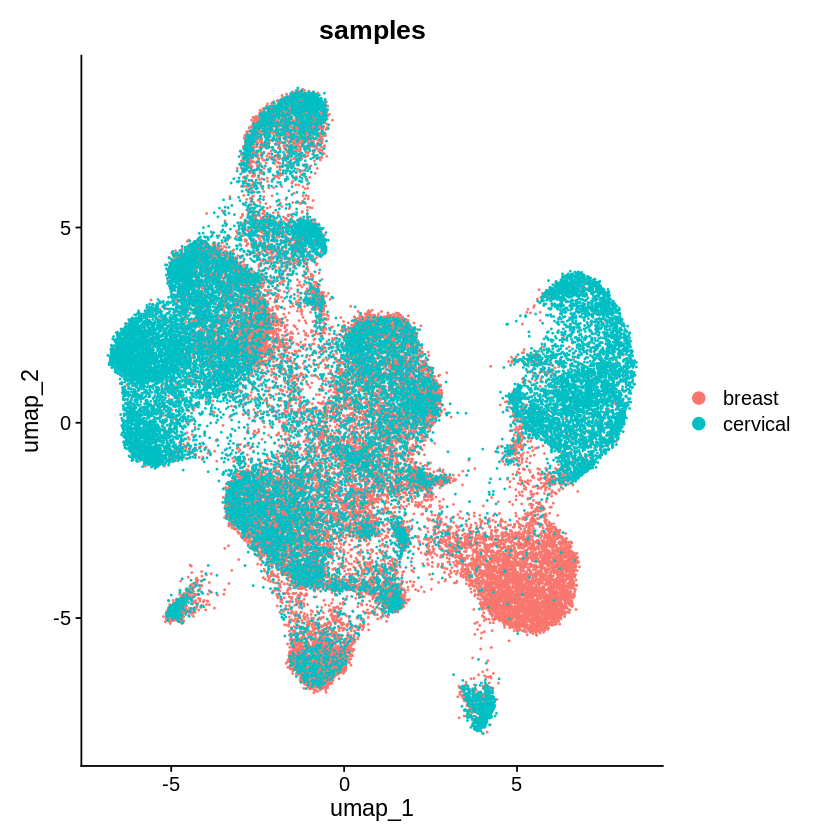

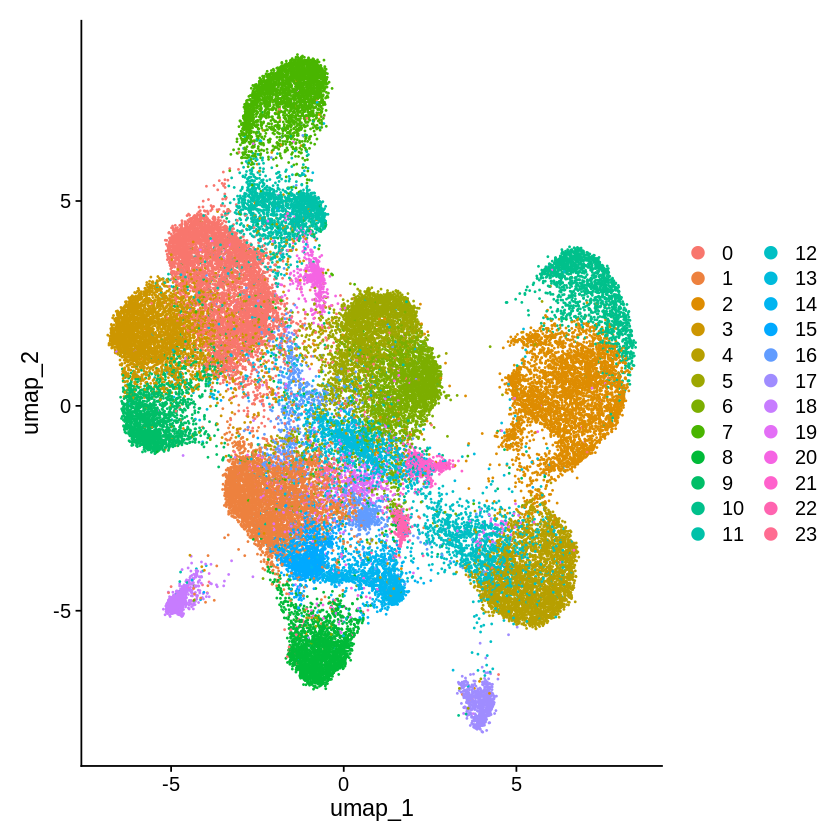

In [ ]:
# plot UMAP after batch correction
DimPlot(merge.obj, group.by = "samples")
DimPlot(merge.obj)

# **Section 9. Project results from "sketch" 50k cells to all cells**

Since harmony space (batch corrected space), UMAP, and clustering are compuated based on 50k "sketch" cells. We can project these results from 50k cells to ALL cells.

 **In workshop, we will skip these two steps, and instead we will directly load the pre-generated results.**

In [ ]:
############################ SKIP these steps in workshop ########################

# proeject harmony results from 50k cells (sketch) to all cells (RNA)
# after projection, harmony space for all cells is generated as harmony.full
# runtime: 46s
merge.obj <- ProjectIntegration(object = merge.obj,
                                sketched.assay = "sketch", assay = "RNA",
                                reduction = "harmony")

# project batch corrected clustering results from 50k cells to all cells ("cluster_full")
# project batch corrected UMAP results from 50k cells to all cells ("full.umap")
# runtime: 8mins
merge.obj <- ProjectData(
  object = merge.obj,
  assay = "RNA",
  full.reduction = "harmony.full",
  sketched.assay = "sketch",
  sketched.reduction = "harmony.full",
  umap.model = "umap",
  dims = 1:30,
  refdata = list(cluster_full = "seurat_clusters")
)

In [ ]:
##################### load pre-generated result in workshop ###########################
merge.obj <- readRDS("./multi-sample-analysis-intermediate-data/Xenium_multiSample_integration_after_ProjectData.rds")

In [ ]:
merge.obj

An object of class Seurat 
10202 features across 1182865 samples within 2 assays 
Active assay: sketch (5101 features, 2000 variable features)
 5 layers present: counts.breast, counts.cervical, data.breast, data.cervical, scale.data
 1 other assay present: RNA
 5 dimensional reductions calculated: pca, umap, harmony, harmony.full, full.umap

After projecting results from 50k cells to all cells, we can visualize UMAP results for all cells after batch correction.

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



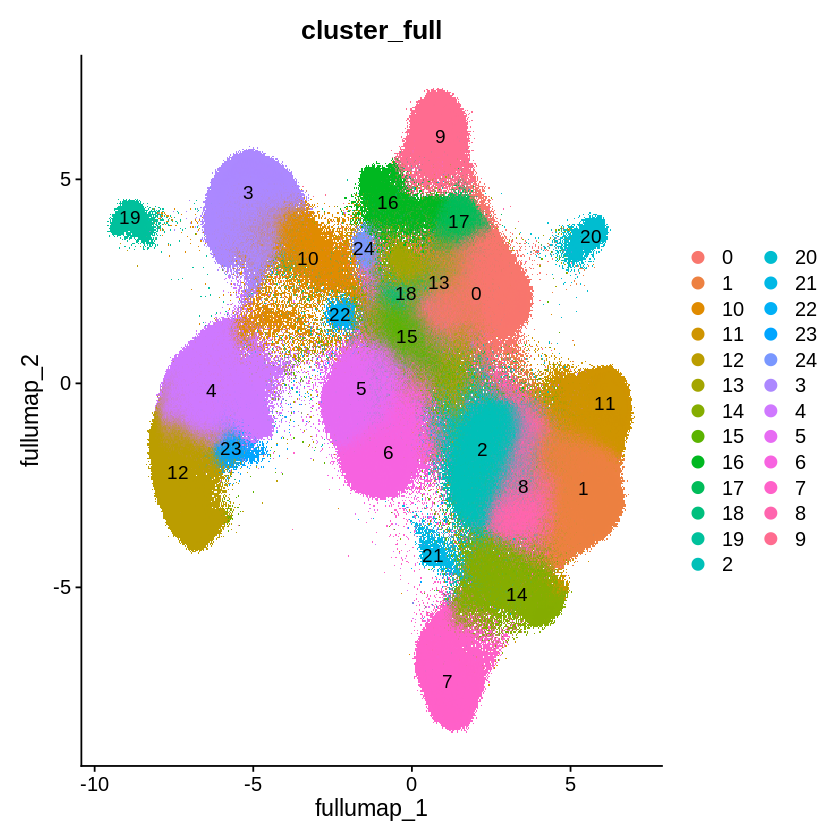

In [ ]:
DimPlot(merge.obj, reduction = "full.umap", group.by = "cluster_full",label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



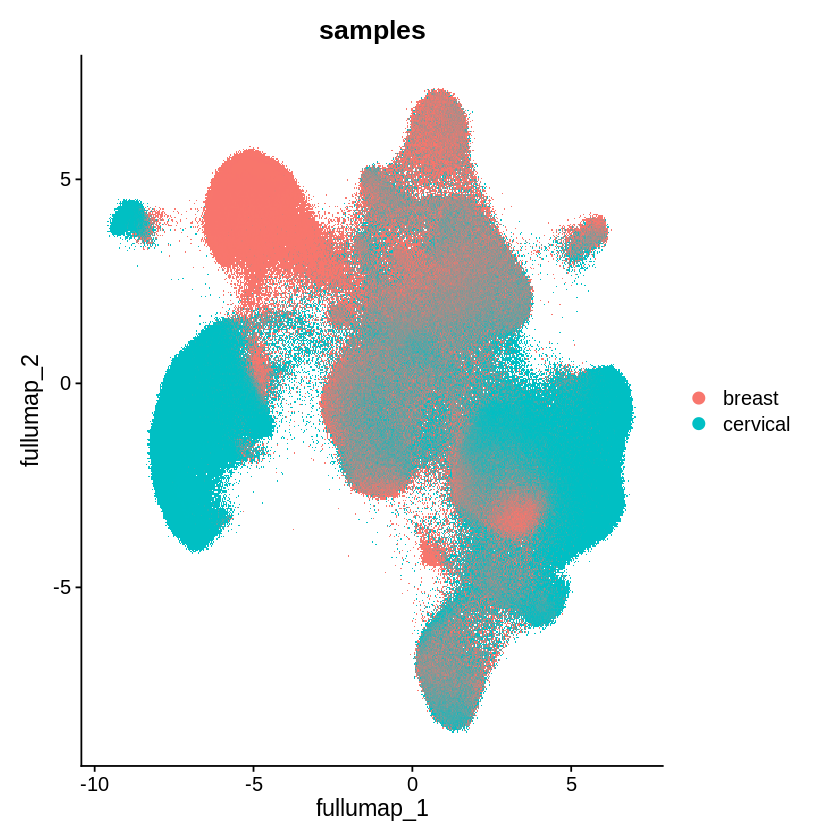

In [ ]:
DimPlot(merge.obj, reduction = "full.umap", group.by = "samples")

# **Section 10. Export all cell clustering results in csv and import to Xenium Explorer**

After batch correction, we can export batch corrected clustering results in csv files for both breast cancer and cervical cancer data separately. We can import each sample's clsutering results (generated by integrative analysis) into its own Xenium Explorer interface.

In [ ]:
clusters_all <- FetchData(merge.obj, vars = c("cluster_full","samples"))

# since we added suffix in cell IDs in section 3.3, here we need to remove suffix, back to original IDs
clusters_all$cell_id <- sapply(strsplit(rownames(clusters_all),"_"),function(X){return(X[1])})
head(clusters_all)

cluster_full samples cell_id   
aaaahjao-1_breast 3            breast  aaaahjao-1
aaaajdej-1_breast 3            breast  aaaajdej-1
aaaakcik-1_breast 3            breast  aaaakcik-1
aaaaknop-1_breast 3            breast  aaaaknop-1
aaaamepl-1_breast 3            breast  aaaamepl-1
aaaanang-1_breast 3            breast  aaaanang-1

In [ ]:
# get clustering results for breast cancer data
clusters_all_breast <- clusters_all[(clusters_all$samples == "breast"),c("cell_id","cluster_full")]
colnames(clusters_all_breast) <- c("cell_id","group")
write.table(clusters_all_breast,"integrated_clusters_for_breast.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

In [ ]:
# get clustering results for cervical cancer data
clusters_all_cervical <- clusters_all[(clusters_all$samples == "cervical"),c("cell_id","cluster_full")]
colnames(clusters_all_cervical) <- c("cell_id","group")
write.table(clusters_all_cervical,"integrated_clusters_for_cervical.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

We can follow section 2.5.4 to import clustering csv file into Xenium Explorer

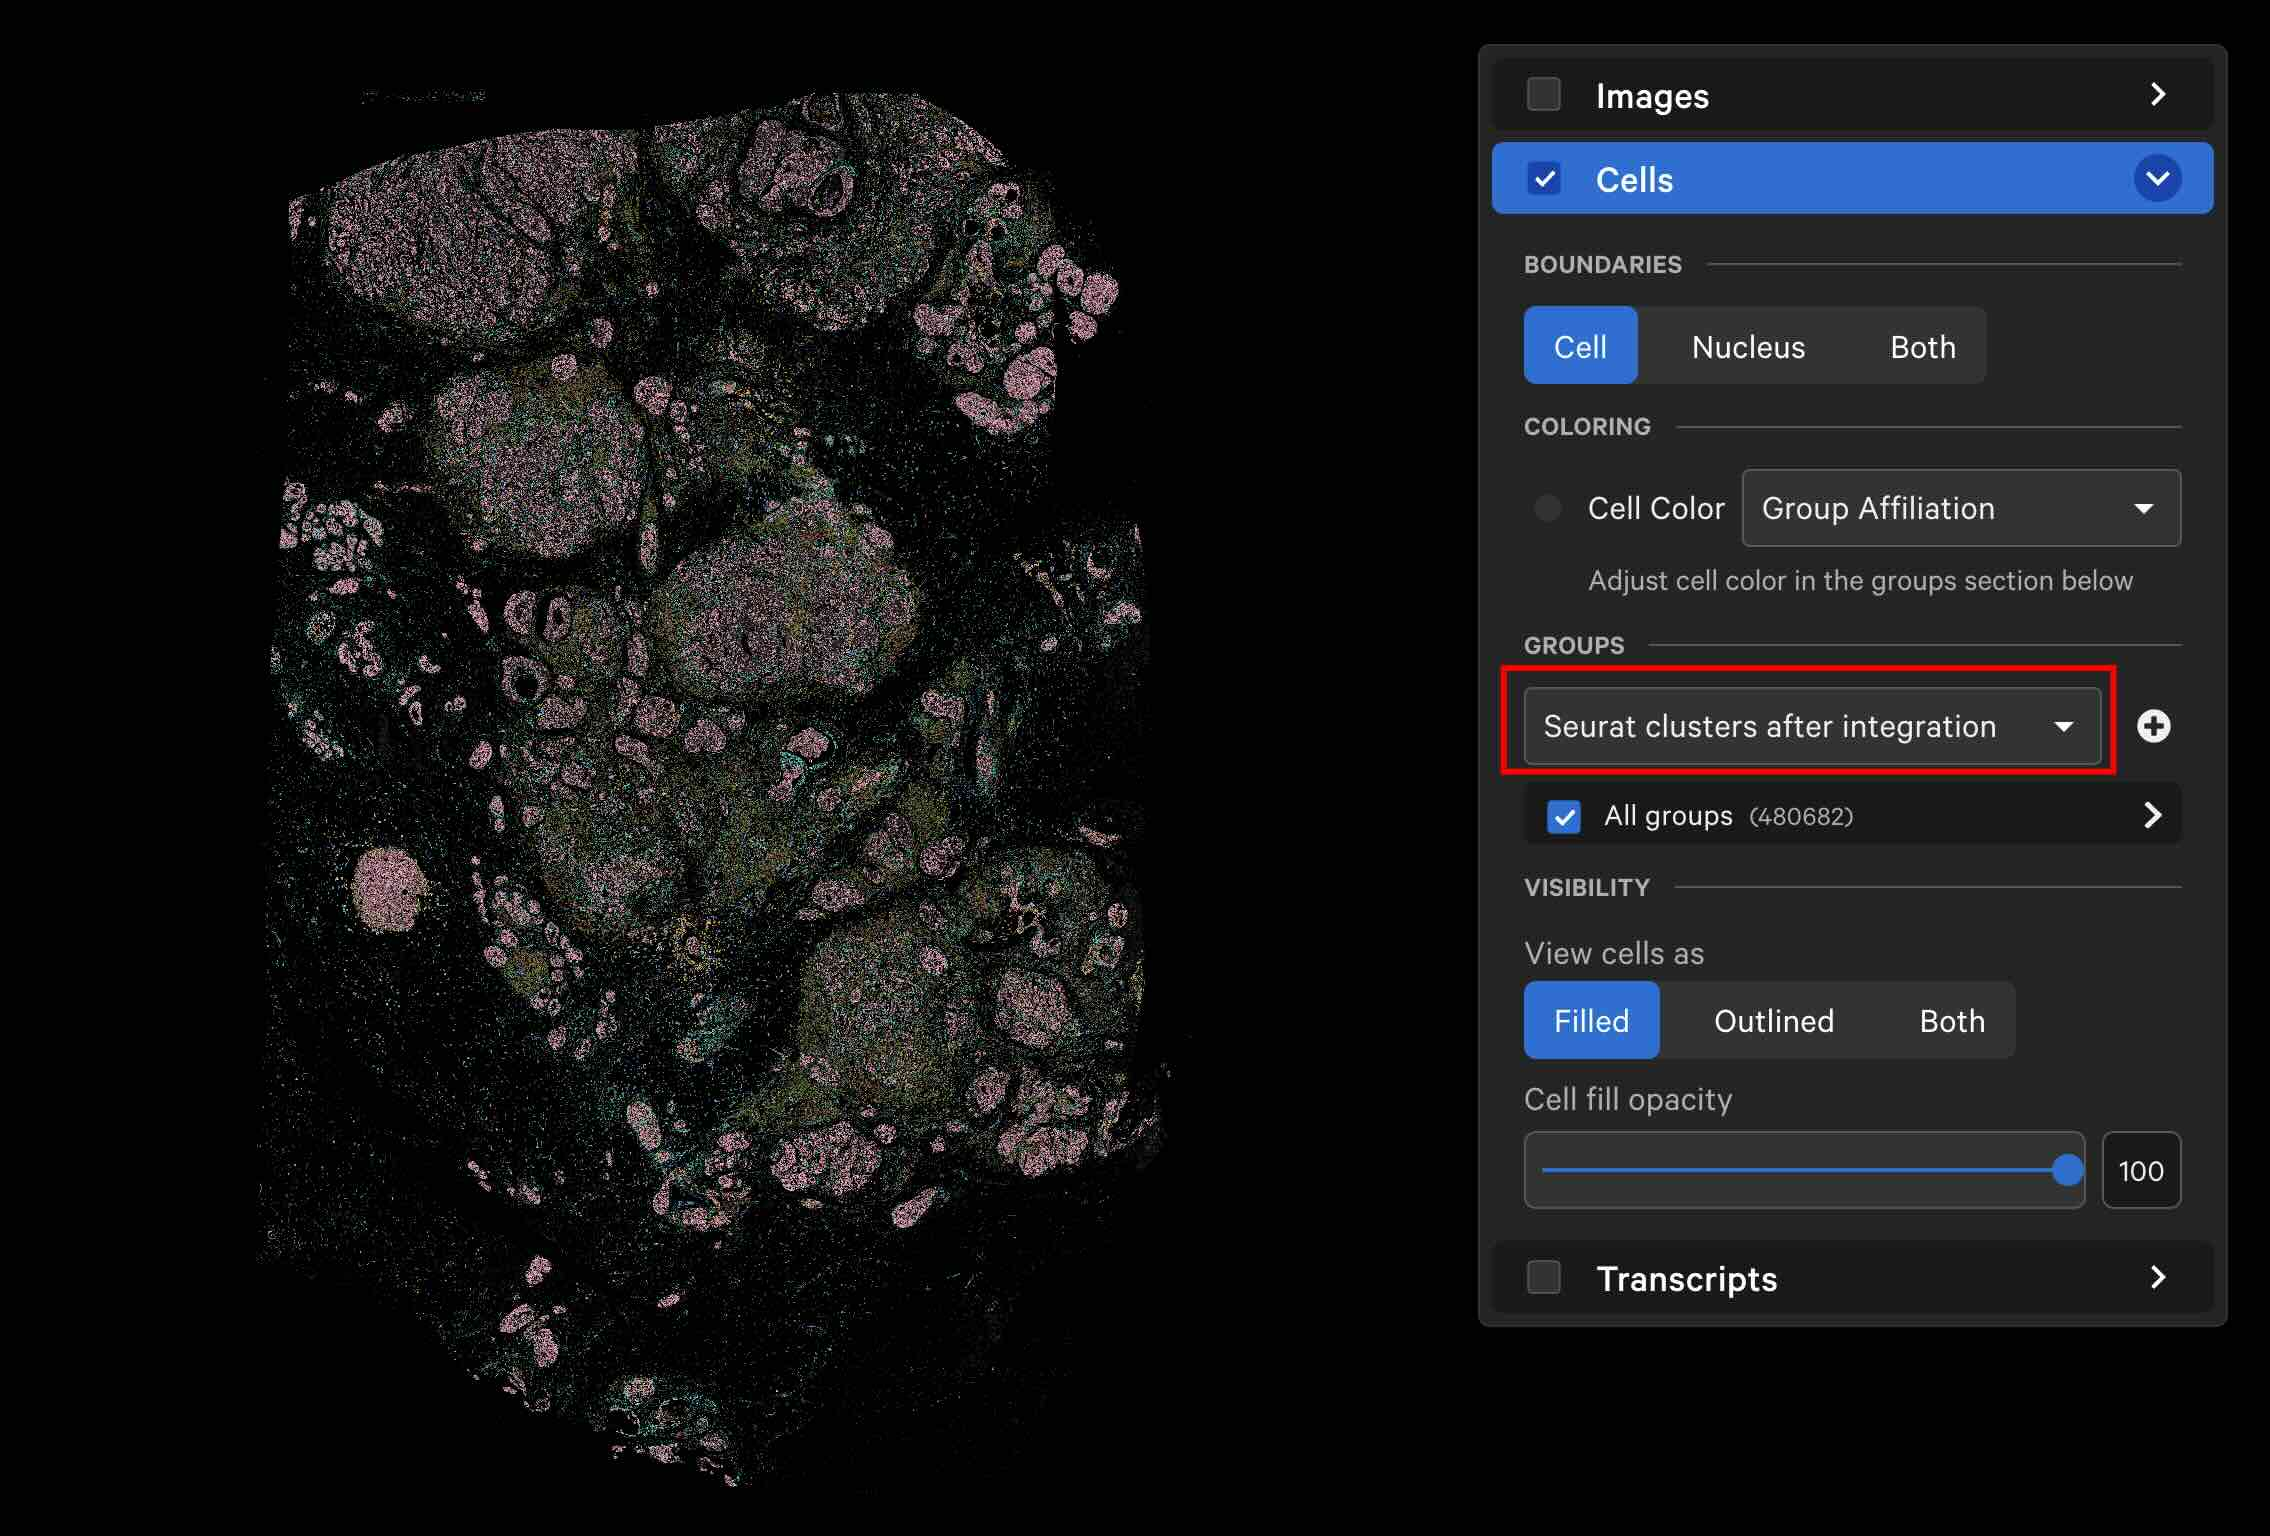

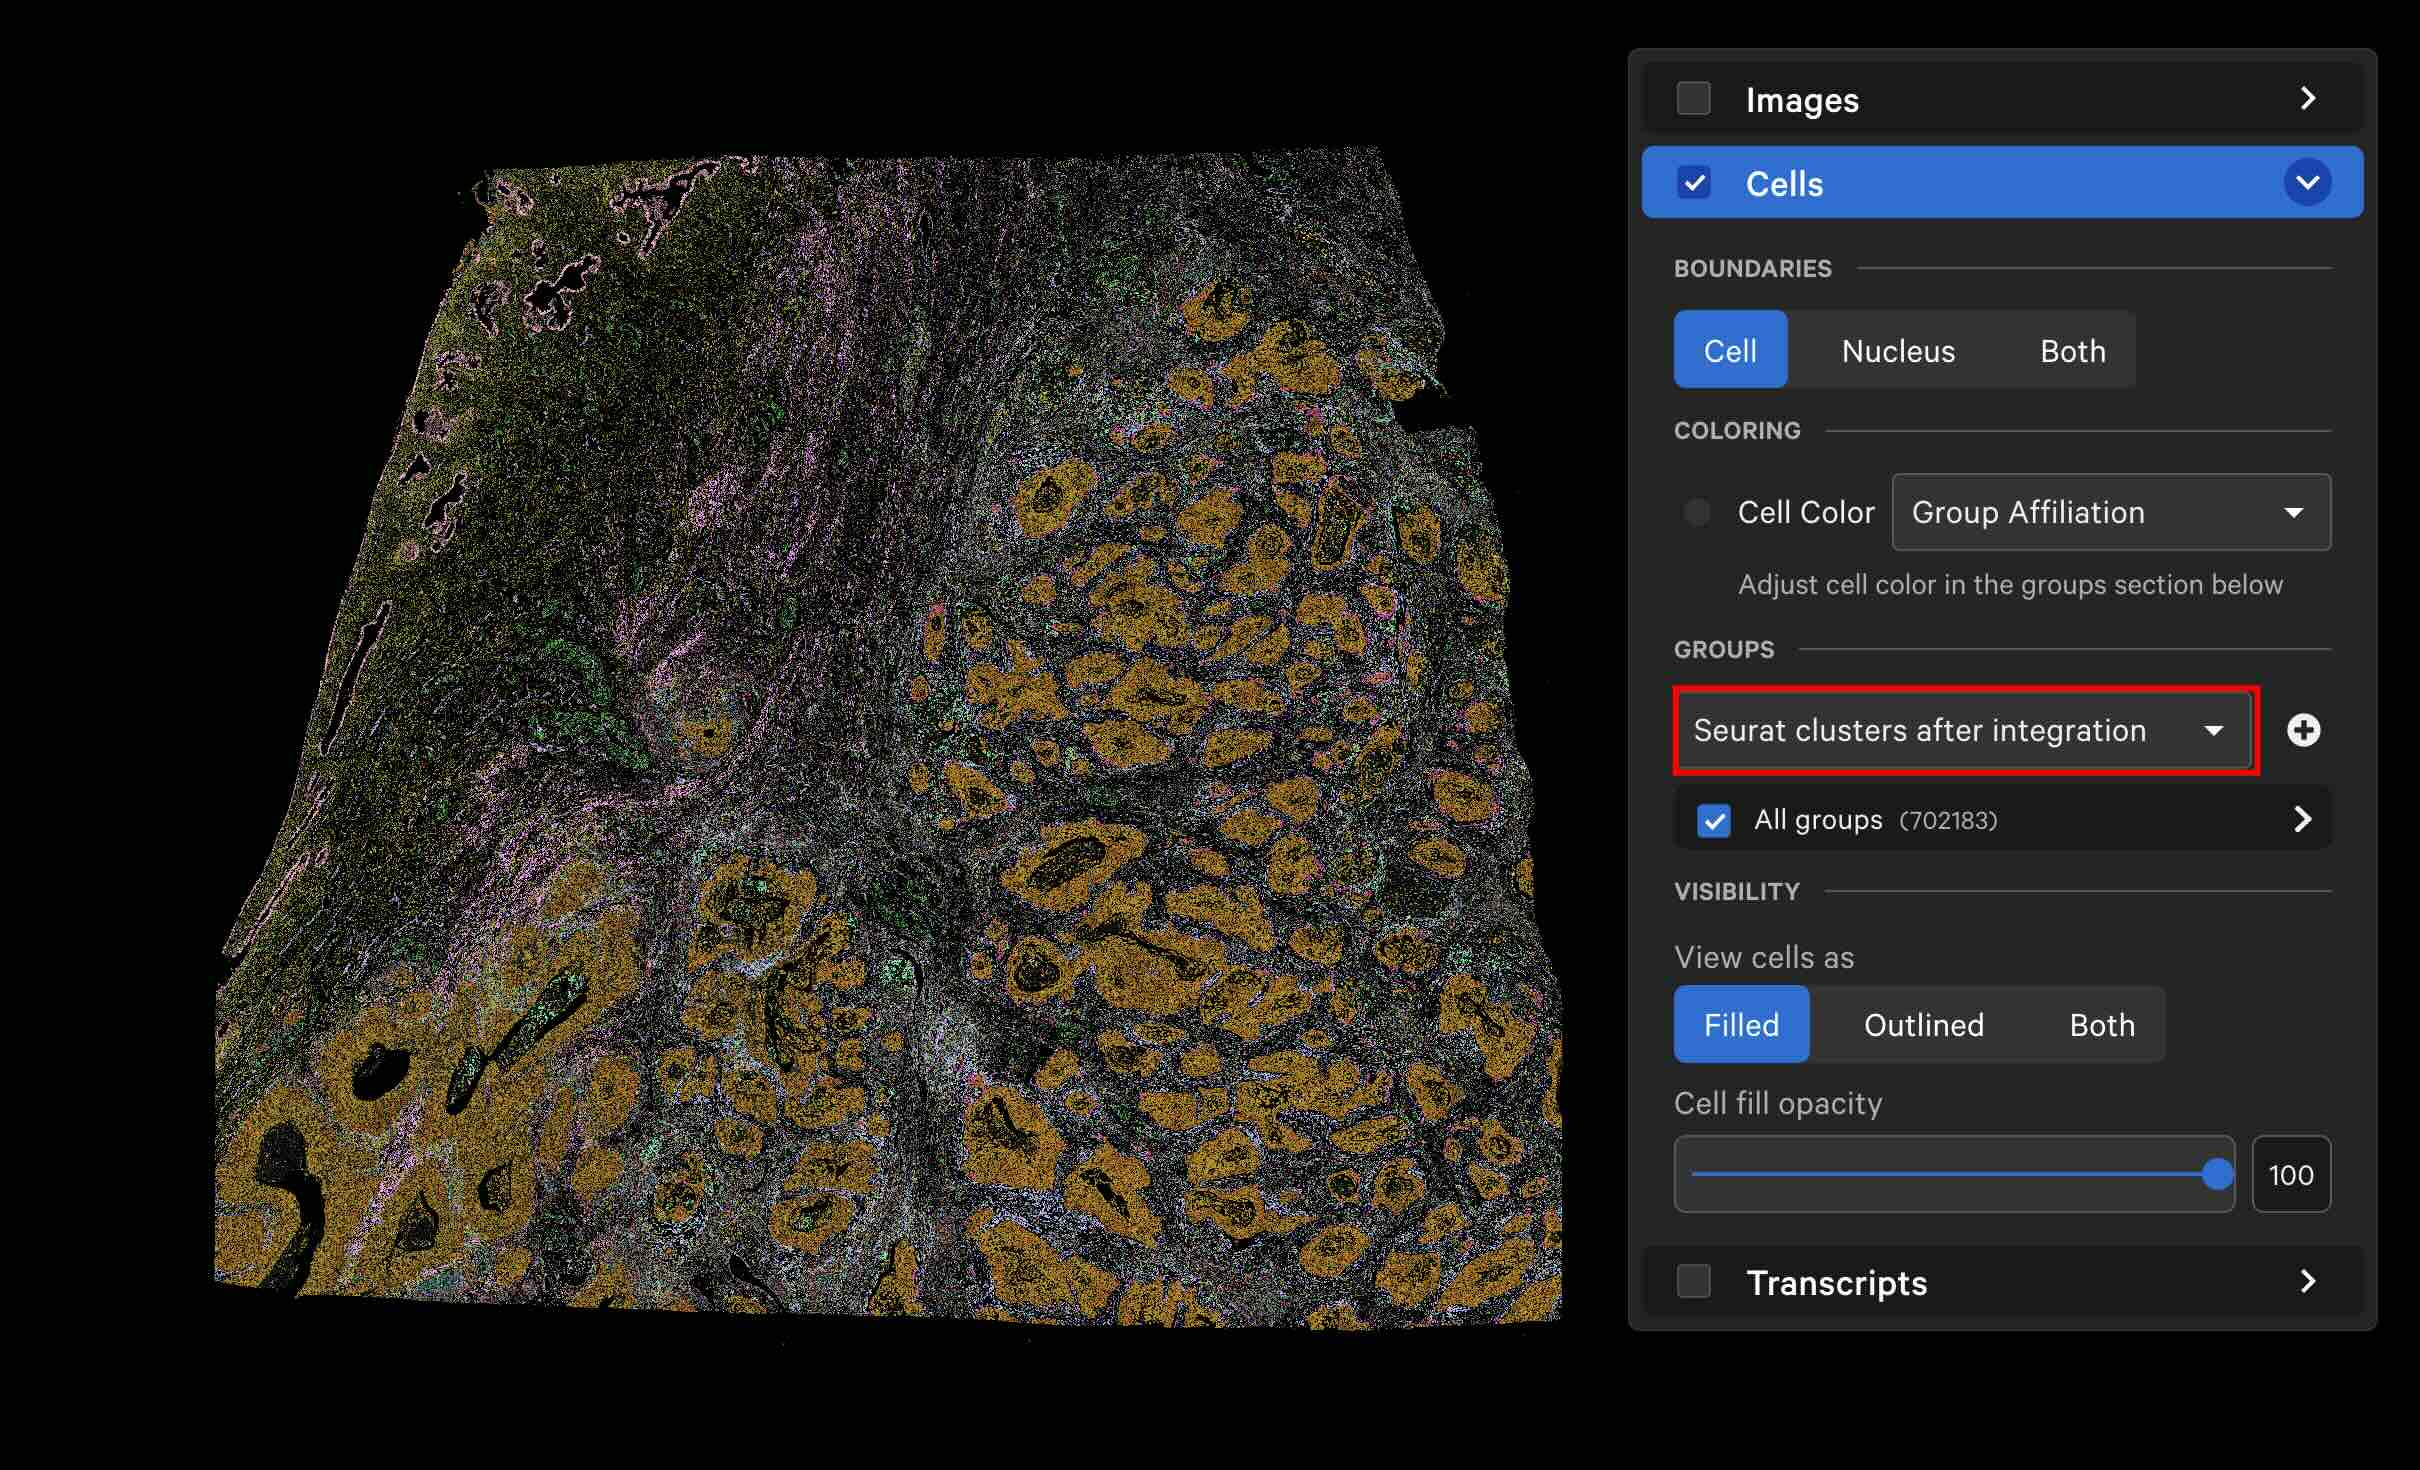

# **Section 11. Find cluster marker genes for cell annotation**

We can compute marker genes in each cluster and accordingly annotate each cluster

In [ ]:
DefaultAssay(merge.obj) <- "sketch"

# join breast and cervical matrices in sketch (50k cells)
merge.obj[["sketch"]] <- JoinLayers(merge.obj[["sketch"]])

# calculate marker genes for each cluster
all.markers <- FindAllMarkers(merge.obj, only.pos = TRUE)

In [ ]:
# save marker gene results in csv
write.table(all.markers,"markers_for_all_clusters_in_sketch.csv", sep=",", col.names = TRUE,
            row.names=FALSE, quote=FALSE)

Based on the marker gene reuslts, we can identify that cluster 5 is highly enriched with macrophage marker genes.


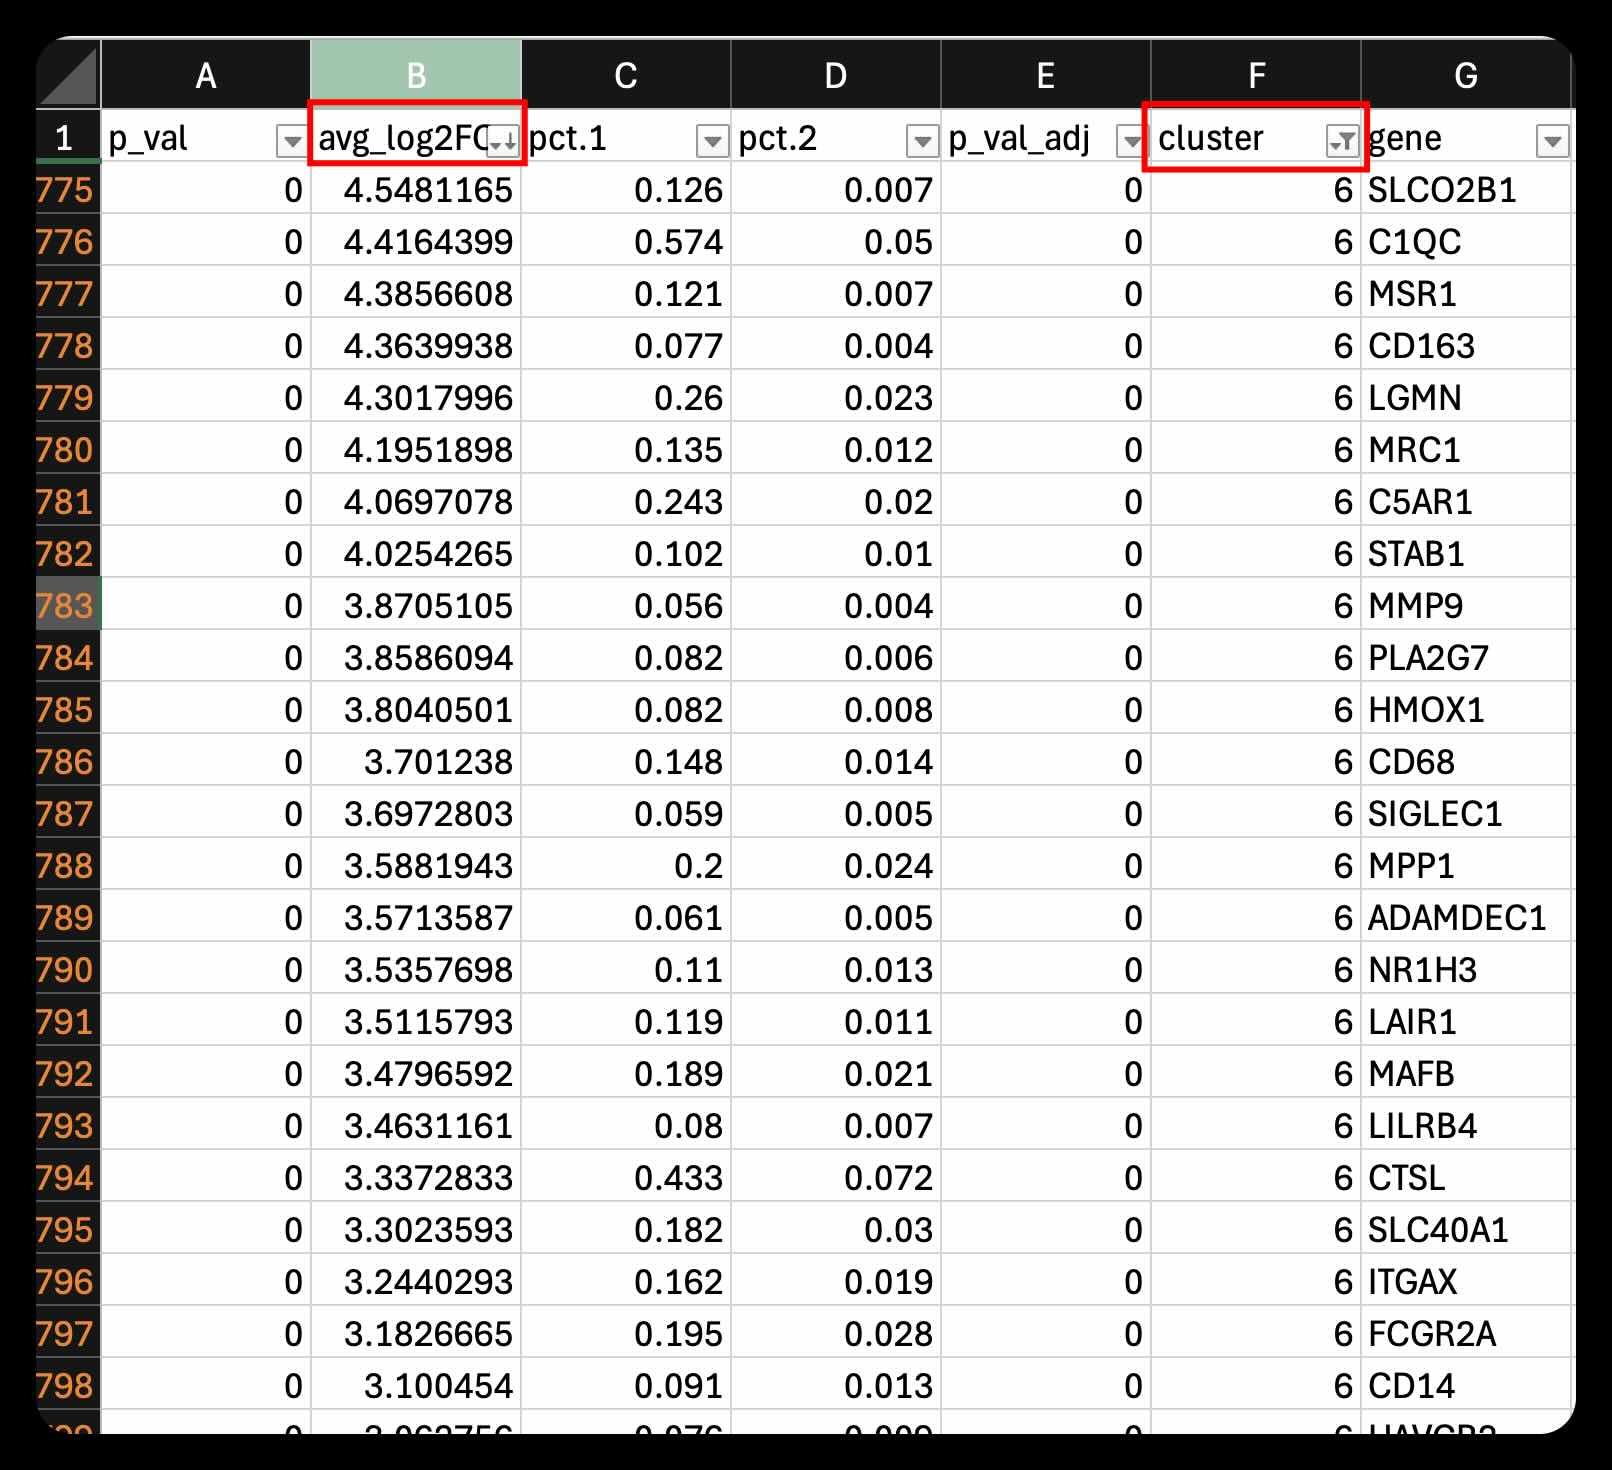

Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
This message is displayed once every 8 hours.


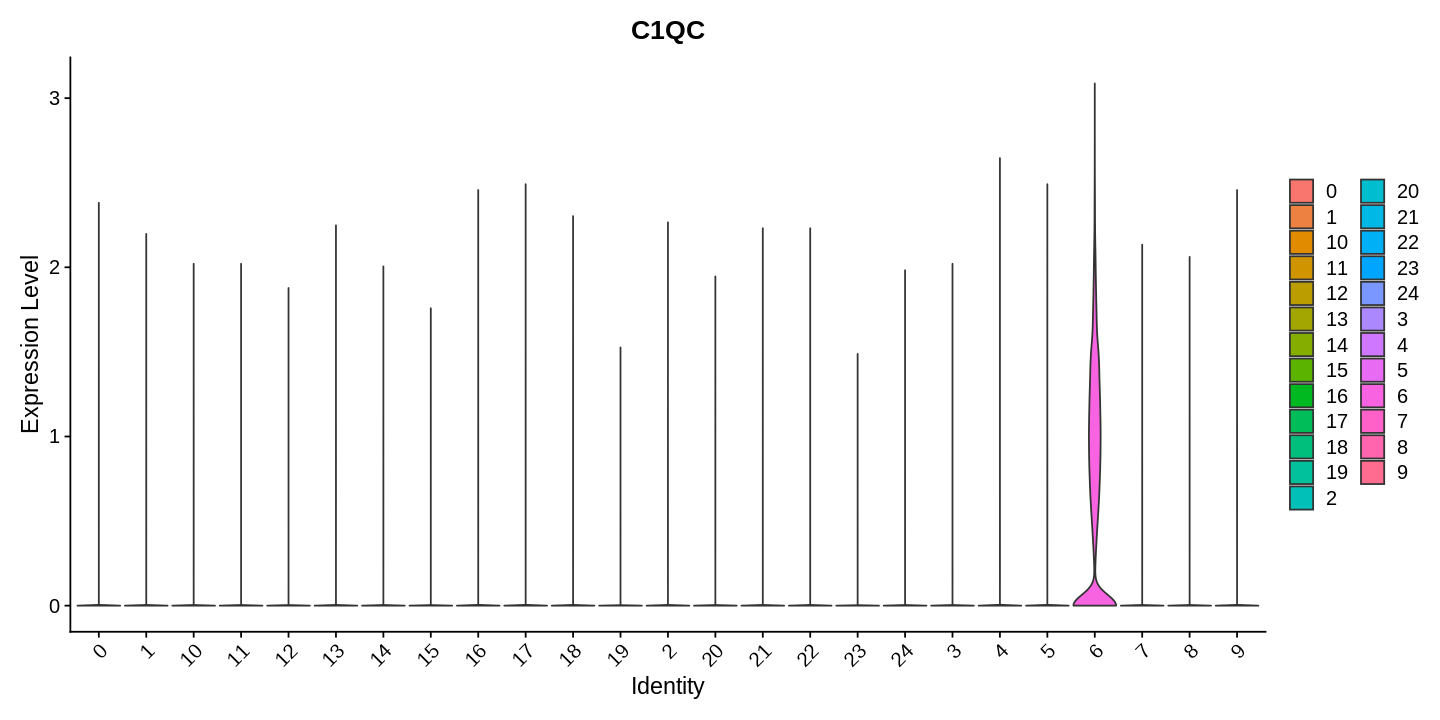

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)
VlnPlot(merge.obj, assay = "RNA", features = c("C1QC"),
        layer="data", pt.size=0, group.by="cluster_full")

### [Tip] How to save this Seurat object (with 50k cells in memory and all cells on disk)?

We can use `saveRDS` to save this Seurat (with sketch) in a rds file locally. Please be noted that since this Seurat object also links to on-disk data (in the folders `xenium_breast_matrix` and `xenum_cervical_matrix`). Hence, the complete saved data: saved Seurat object rds file + all on-disk data folders.

In [ ]:
# save integrated Seurat object in rds
saveRDS(merge.obj, "Xenium_integrated_Seurat.rds")

In this demo case, we need to keep `Xenium_integrated_Seurat.rds` + `xenium_breast_matrix/` + `xenum_cervical_matrix/` as a whole

Next time when we re-load this integrated Seurat object, we just need to use `readRDS` to read rds file. Of course, on-disk data folders also need to be there (`xenium_breast_matrix` and `xenum_cervical_matrix`).

In [ ]:
# reload integrated Seurat object from rds
merge.obj <- readRDS("./Xenium_integrated_Seurat.rds")

-------- End of Tip

# **Section 12. Subset Seurat for macrophages**

Below we subset macrophages only and compare gene expression in macrophages between breast cancer and cervical cancer data. Below demonstration is more for explorative purpose to compare macrophages between two tissues. The p-values obtained from this analysis should be interpreted with caution, because these tests treat each bin as an independent replicate, which could cause false positives.

**A more robust statistic test for differential expression genes (DEG) between conditions requires biological replicates (at least 3 biological replicates per condition are recommended) and pseudo-bulk DEG analysis approach can be used for this analysis.** See more documentations below:

*   [Differential Gene Expression Analysis in scRNA-seq Data between Conditions with Biological Replicates](https://www.10xgenomics.com/analysis-guides/differential-gene-expression-analysis-in-scrna-seq-data-between-conditions-with-biological-replicates)
*   [Use Seurat for pseudo-bulk DE analysis](https://satijalab.org/seurat/articles/de_vignette#perform-de-analysis-after-pseudobulking)


In [ ]:
# get all cell IDs for cluster 6 (macrophage)
macrophage_cells <- names(merge.obj$cluster_full[(merge.obj$cluster_full == 6)])

In [ ]:
# based on macrophage cell IDs, subset Seurat object
macro.obj <- subset(merge.obj, cells = macrophage_cells)

Re-do analyses: Find variable genes, data scaling, PCA, harmony correction (on PCA), UMAP projection and clustering on macrophage cells only.

Since only 54k macrophages, we will do analysis on all cells (`RNA` assay).

The following steps can take quite long time. **For in-person events, we will skip them and directly load pre-generated result.**

In [ ]:
################### SKIP these steps for in-person events ###################

DefaultAssay(macro.obj) <- "RNA"
macro.obj <- FindVariableFeatures(macro.obj, verbose = FALSE)
macro.obj <- ScaleData(macro.obj, verbose = FALSE)
macro.obj <- RunPCA(macro.obj, verbose = FALSE)

# batch correction using harmony
# correcting PCA
# corrected space is named as harmony.full
macro.obj <- IntegrateLayers(macro.obj, method = HarmonyIntegration,
                             orig = "pca", new.reduction = "harmony.full",
                             dims = 1:30)

# run UMAP on corrected space (harmony.full)
macro.obj <- RunUMAP(macro.obj, reduction = "harmony.full", dims = 1:30,
                     reduction.name = "umap.full",
                     reduction.key = "UMAP_full_", verbose = FALSE)

In [ ]:
##################### load pre-generated result in for in-person events ###########################

macro.obj <- readRDS("/content/multi-sample-analysis-intermediate-data/macrophage_seurat_result.rds")

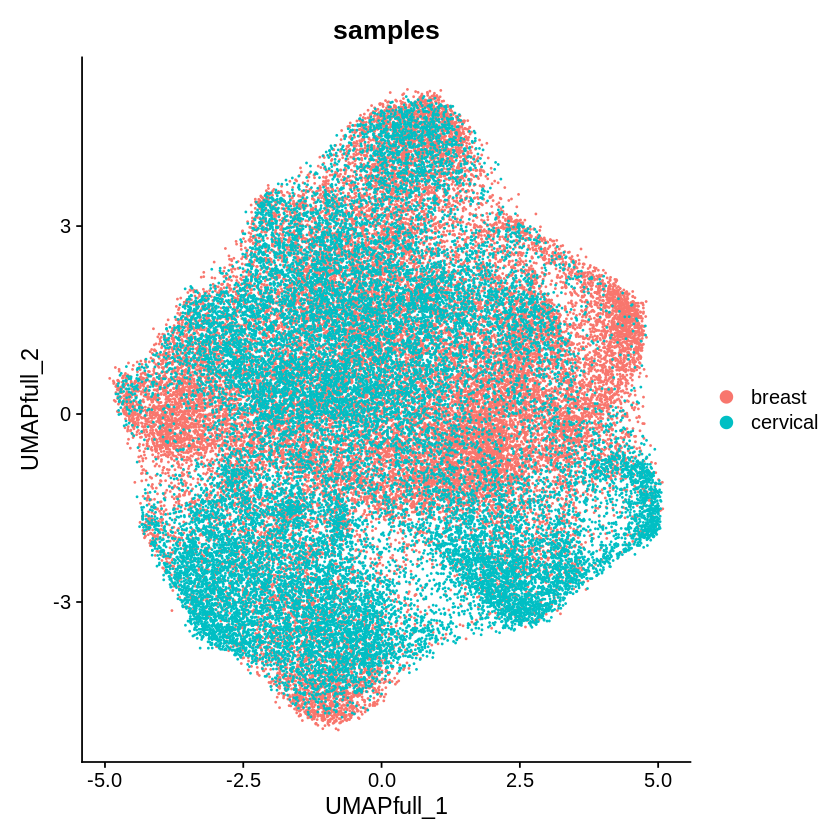

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(macro.obj, reduction = "umap.full", group.by = "samples")

Compute DEG in macrophages between breast cancer and cervical cancer data.

In [ ]:
Idents(object = macro.obj) <- "samples"
macro.obj[["RNA"]] <- JoinLayers(macro.obj[["RNA"]])
macr.marker <-  FindMarkers(macro.obj, ident.1 = "breast", ident.2 = "cervical")

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


In [ ]:
# save DEG results in csv
macr.marker$gene <- rownames(macr.marker)
write.table(macr.marker,"macrophage_DGE.csv", sep=",", col.names = TRUE,
            row.names=FALSE, quote=FALSE)

Based on DEG results, CTSL is significantly higher expressed in breast cancer macrophages compared to cervical cancer.

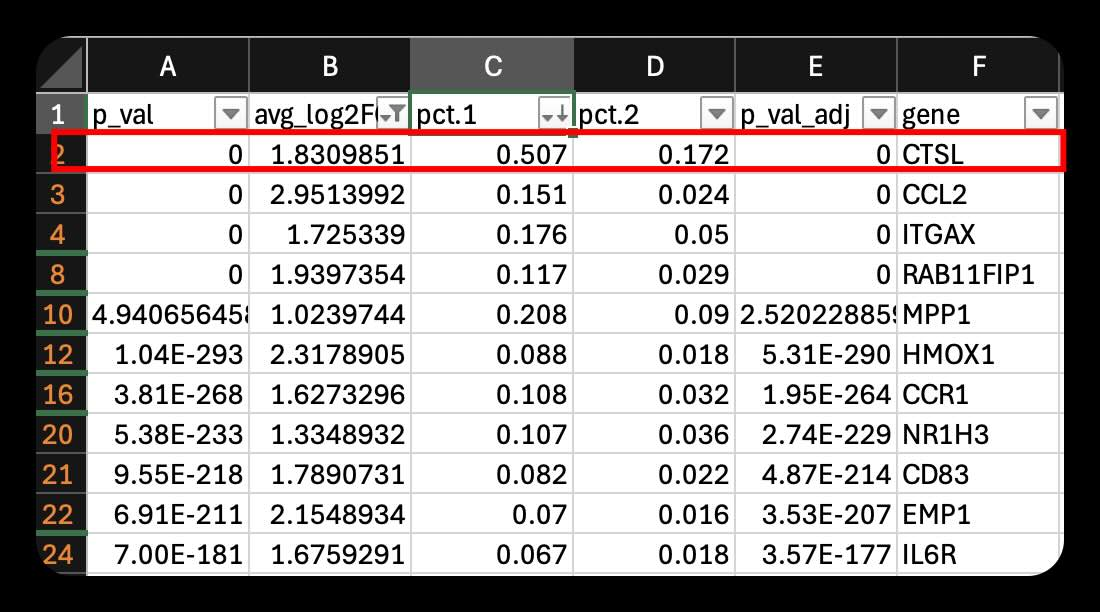

Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
This message is displayed once every 8 hours.


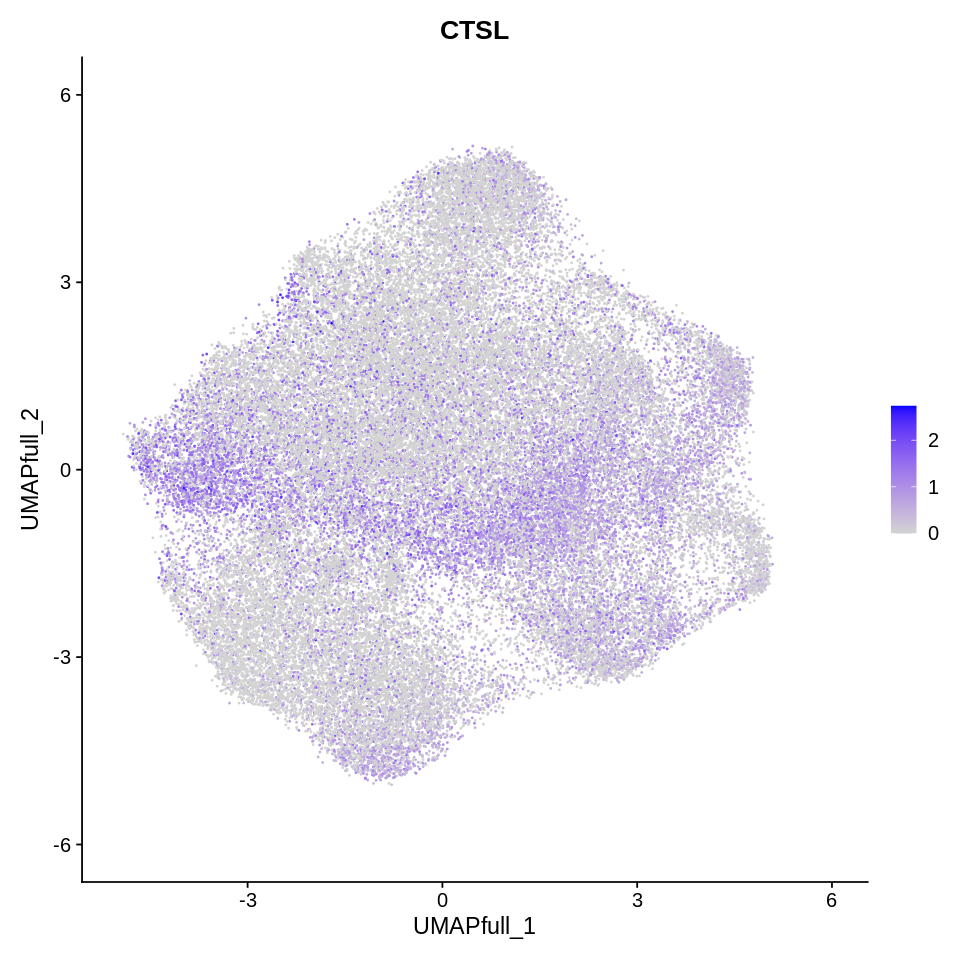

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(macro.obj, features = c("CTSL"),
               reduction = "umap.full")

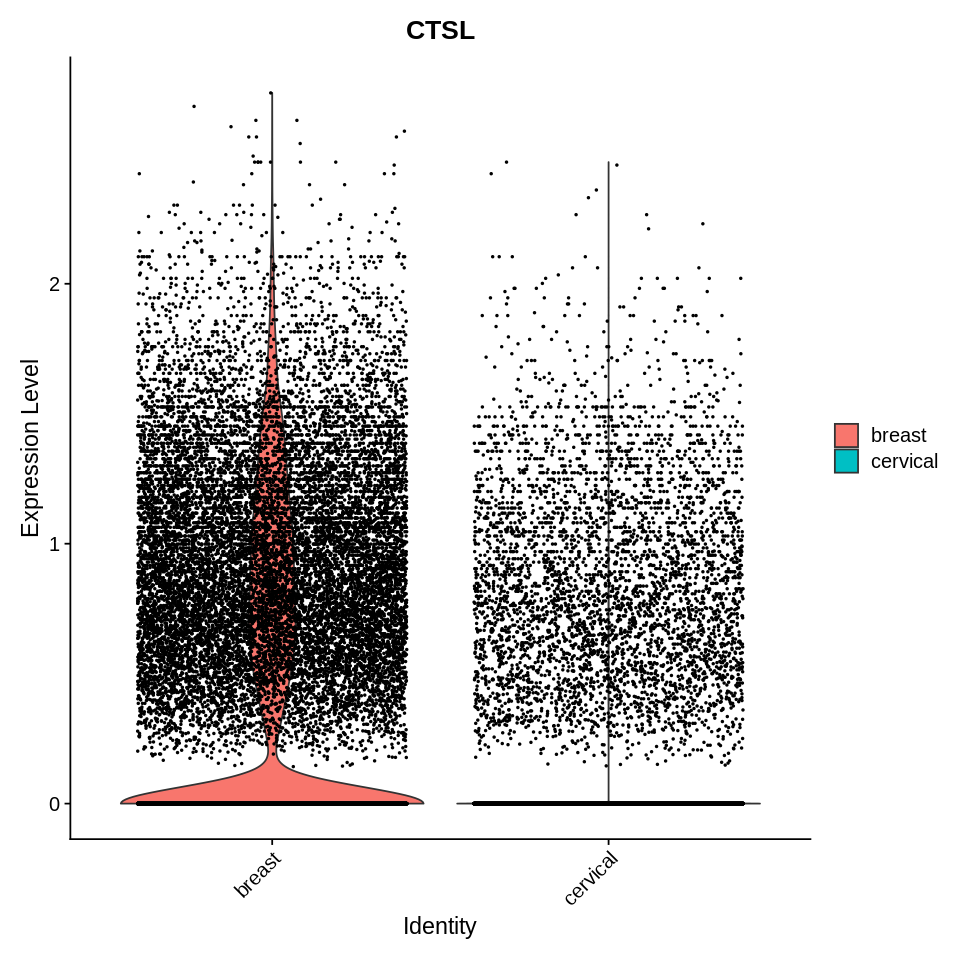

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
VlnPlot(macro.obj, "CTSL", group.by = "samples")

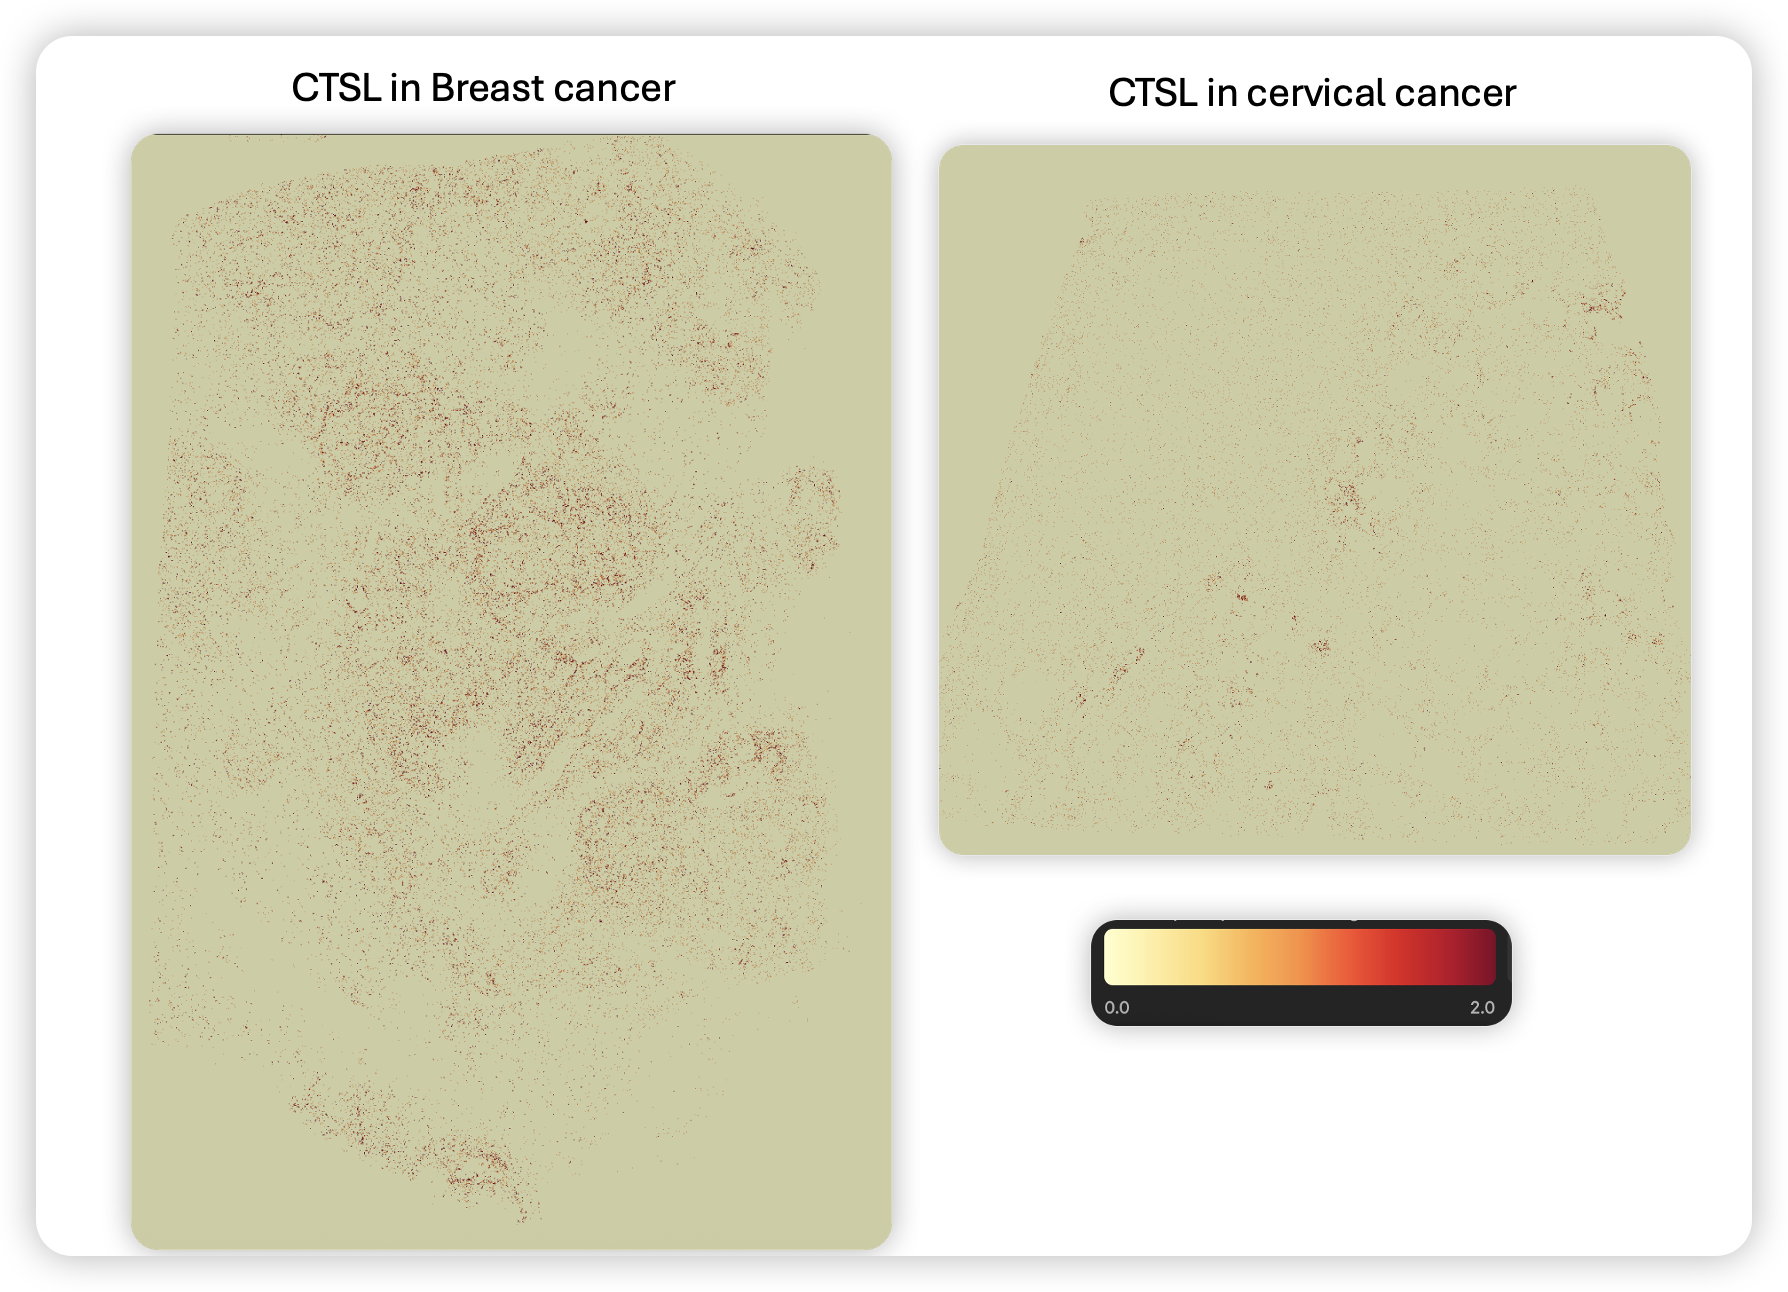

Higher expression of CTSL in macrophages is reported to be associated with tumor progression and poor prognosis ([Zhang, et al., 2024](https://www.sciencedirect.com/science/article/pii/S2405844024053040), [Alderton, 2010](https://www.nature.com/articles/nrc2816), [Xiao, et al., 2024](https://www.wjgnet.com/1007-9327/full/v30/i47/5032.htm)). Our analysis shows higher expression of CTSL in macrophages of breast cancer tissue, suggesting a more pro-tumor role of macrophages in breast cancer (this tested data) compared to cervical cancer (this tested data).